In [9]:
from autoencoder.autoencoder import AutoEncoder
import torch
import pickle
from autoencoder.loss import Loss
from sindy_network import SINDy
from sindy.SINDy_library import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
device = 'cuda'
import numpy as np
import dill
  

In [10]:
params = pickle.load(open('utils/model1_params.pkl', 'rb'))

encoder = AutoEncoder(params, 'encoder')
decoder = AutoEncoder(params, 'decoder')
sindy = dill.load(open(f'model_lorenz_1_1000', 'rb'))
sindy.to(device)
training_data = pickle.load(open('dataset_generation/test_data.pkl', 'rb'))

criterion = Loss(
        params['loss_weight_decoder'],
        params['loss_weight_sindy_z'],
        params['loss_weight_sindy_x'],
        params['loss_weight_sindy_regularization']
        )
    
def run():
    x, dx, dz_predict, dz, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z = sindy(torch.from_numpy(training_data['x']).to(device=device), torch.from_numpy(training_data['dx']).to(device=device), torch.from_numpy(training_data['ddx']).to(device=device))
    loss = criterion(x, dx, dz, dz_predict, x_decode, dx_decode, sindy_coefficients, ddz, ddx, ddx_decode, sindy.coefficient_mask)
             
    return x, dx, dz, dz_predict, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z, loss  

In [11]:
x, dx, dz, dz_pred, x_decode, dx_decode, sindy_coefficients, sindy_predict, ddz, ddx, ddx_decode, z, loss = run()

In [17]:
sindy_coefficients = sindy_coefficients.to('cpu').detach()
z = z.to('cpu').detach()#.numpy()
a1 = 1
a2 = training_data['sindy_coefficients'][2,0]/sindy_coefficients[2,0]
a3 = np.sqrt(sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
b3 = -sindy_coefficients[0,2]/sindy_coefficients[3,2]

sindy_coefficients_transformed = np.zeros(sindy_coefficients.shape)
sindy_coefficients_transformed[1,0] = sindy_coefficients[1,0]
sindy_coefficients_transformed[2,0] = sindy_coefficients[2,0]*a2/a1
sindy_coefficients_transformed[1,1] = sindy_coefficients[6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = sindy_coefficients[2,1]
sindy_coefficients_transformed[6,1] = sindy_coefficients[6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = sindy_coefficients[3,2]
sindy_coefficients_transformed[5,2] = sindy_coefficients[5,2]*a1*a2/a3

z0_transformed = np.array([z[0,0]/a1,
                           z[0,1]/a2,
                           (z[0,2] - b3)/a3])

print(sindy_coefficients)

tensor([[-5.2630e-02, -2.6185e-02,  7.1148e-01],
        [-4.4009e-02,  2.3602e-02, -4.9072e-02],
        [ 1.9142e-01,  5.0389e-02,  2.8308e-01],
        [-5.4290e-01, -3.3883e-02,  1.6699e-04],
        [ 8.7651e-02, -2.2960e-02, -1.3281e+00],
        [ 6.7333e-02, -3.8097e-01, -2.3211e-02],
        [-3.5891e-02, -4.3048e-04,  1.0285e-02],
        [ 1.2722e-01, -1.9083e-02, -2.8864e-02],
        [ 2.4637e+00,  3.9524e-01, -3.1228e-01],
        [-3.1940e-02, -1.5167e-02,  9.1976e-01],
        [-3.0051e-02, -1.0353e-01,  1.0943e+00],
        [ 2.5987e-02,  3.7156e-01,  1.0961e+00],
        [-9.0866e-01,  3.9979e-01,  6.0607e-01],
        [-6.8170e-01,  1.2204e+00, -2.0211e-02],
        [-1.5745e+00,  1.0842e+00, -2.0668e-02],
        [-2.5190e-02, -1.0773e-02, -1.7174e-02],
        [-1.0187e+00,  8.1719e-03, -9.1091e-02],
        [-2.5300e-02, -1.9104e-02, -1.9080e-02],
        [-4.6177e-02,  6.0573e-01, -5.9152e-01],
        [-2.2553e-02,  1.0167e+00,  9.8824e-02]], dtype=torch.float64

In [23]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])
lorenz_sim = sindy_simulate(training_data['z'][0, 0], t, training_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(torch.Tensor.cpu(z[0]).numpy(), t, torch.Tensor.cpu(sindy_coefficients).numpy(),
                       params['poly_order'], params['include_sine'])
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                   params['poly_order'], params['include_sine'])

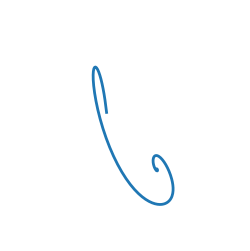

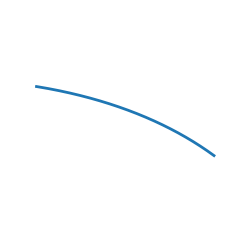

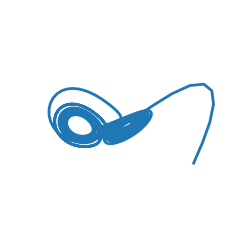

In [24]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

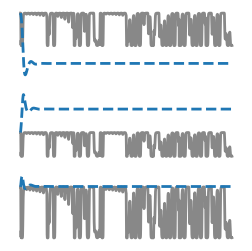

In [25]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, z[:2000,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

Parameter containing:
tensor([[-5.2630e-02, -2.6185e-02,  7.1148e-01],
        [-4.4009e-02,  2.3602e-02, -4.9072e-02],
        [ 1.9142e-01,  5.0389e-02,  2.8308e-01],
        [-5.4290e-01, -3.3883e-02,  1.6699e-04],
        [ 8.7651e-02, -2.2960e-02, -1.3281e+00],
        [ 6.7333e-02, -3.8097e-01, -2.3211e-02],
        [-3.5891e-02, -4.3048e-04,  1.0285e-02],
        [ 1.2722e-01, -1.9083e-02, -2.8864e-02],
        [ 2.4637e+00,  3.9524e-01, -3.1228e-01],
        [-3.1940e-02, -1.5167e-02,  9.1976e-01],
        [-3.0051e-02, -1.0353e-01,  1.0943e+00],
        [ 2.5987e-02,  3.7156e-01,  1.0961e+00],
        [-9.0866e-01,  3.9979e-01,  6.0607e-01],
        [-6.8170e-01,  1.2204e+00, -2.0211e-02],
        [-1.5745e+00,  1.0842e+00, -2.0668e-02],
        [-2.5190e-02, -1.0773e-02, -1.7174e-02],
        [-1.0187e+00,  8.1719e-03, -9.1091e-02],
        [-2.5300e-02, -1.9104e-02, -1.9080e-02],
        [-4.6177e-02,  6.0573e-01, -5.9152e-01],
        [-2.2553e-02,  1.0167e+00,  9.8824e-02]

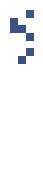

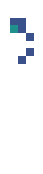

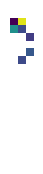

In [21]:
Xi_plot = (params['coefficient_mask']*sindy_coefficients.numpy())
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(training_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

print(sindy.sindy_coefficients)